## Imports

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

## Data

In [2]:
df = pd.read_csv('RSCCASN.csv', index_col='DATE', parse_dates=True)
df.columns = ['Sales']

In [3]:
display(df.head())
df.shape

,Sales
DATE,
1992-01-01,6938.0
1992-02-01,7524.0
1992-03-01,8475.0
1992-04-01,9401.0
1992-05-01,9558.0


(380, 1)

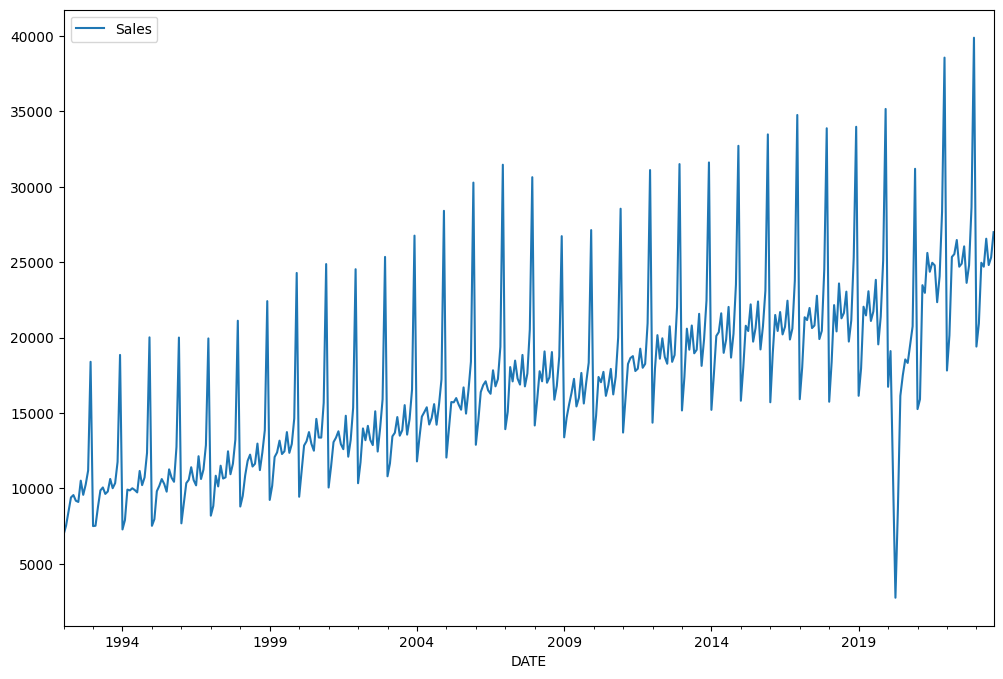

In [4]:
df.plot(figsize=(12,8));

## Train Test Split

In [5]:
test_size = 18
test_ind = len(df)- test_size
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

## Scale Data

In [8]:
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler()

In [9]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

In [11]:
# Let's redefine to get 12 months back and then predict the next month out
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [12]:
# What does the first batch look like?
X,y = generator[0]

In [13]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.11688819 0.13325142 0.15980677 0.18566402 0.19004803 0.17954875
 0.17734279 0.21671507 0.19046688 0.20948285 0.23553557 0.43680889]
Predict this y: 
 [[0.1326371]]


### Create the Model

In [15]:
# We're only using one feature in our time series
n_features = 1

In [16]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and creating a Validation Generator

In [19]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [20]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [21]:
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20


C:\Users\diasrodr\AppData\Local\Temp\ipykernel_27700\3502985036.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,


350/350 [==============================] - 7s 12ms/step - loss: 0.0196 - val_loss: 7.8721e-04
Epoch 2/20
350/350 [==============================] - 8s 24ms/step - loss: 0.0137 - val_loss: 0.0056
Epoch 3/20
350/350 [==============================] - 6s 18ms/step - loss: 0.0092 - val_loss: 0.0013


In [22]:
losses = pd.DataFrame(model.history.history)

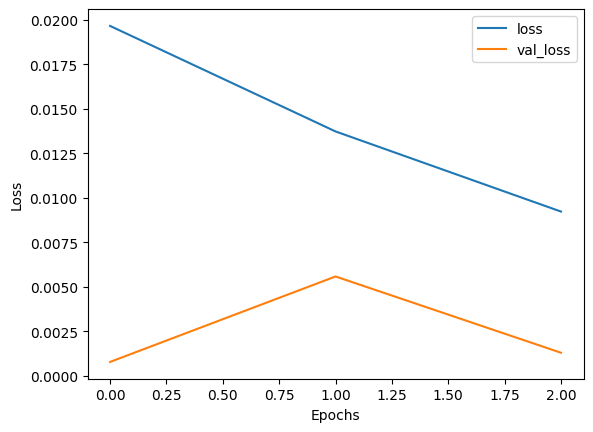

In [26]:
plt.plot(losses);
plt.xlabel('Epochs');
plt.ylabel('Loss');
plt.legend(losses.columns);

## Evaluate on Test Data

In [29]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 56ms/step


## Inverse Transformations and Compare

In [30]:
true_predictions = scaler.inverse_transform(test_predictions)

In [31]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

C:\Users\diasrodr\AppData\Local\Temp\ipykernel_27700\1339453577.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [32]:
test

,Sales,Predictions
DATE,,
2022-03-01,25347.0,22754.856644
2022-04-01,25539.0,22488.166660
2022-05-01,26470.0,23680.159187
2022-06-01,24701.0,23009.313456
2022-07-01,24904.0,23215.695673
2022-08-01,26049.0,23050.478475
2022-09-01,23629.0,21830.275582
2022-10-01,24787.0,22544.760290
2022-11-01,28645.0,24852.938526


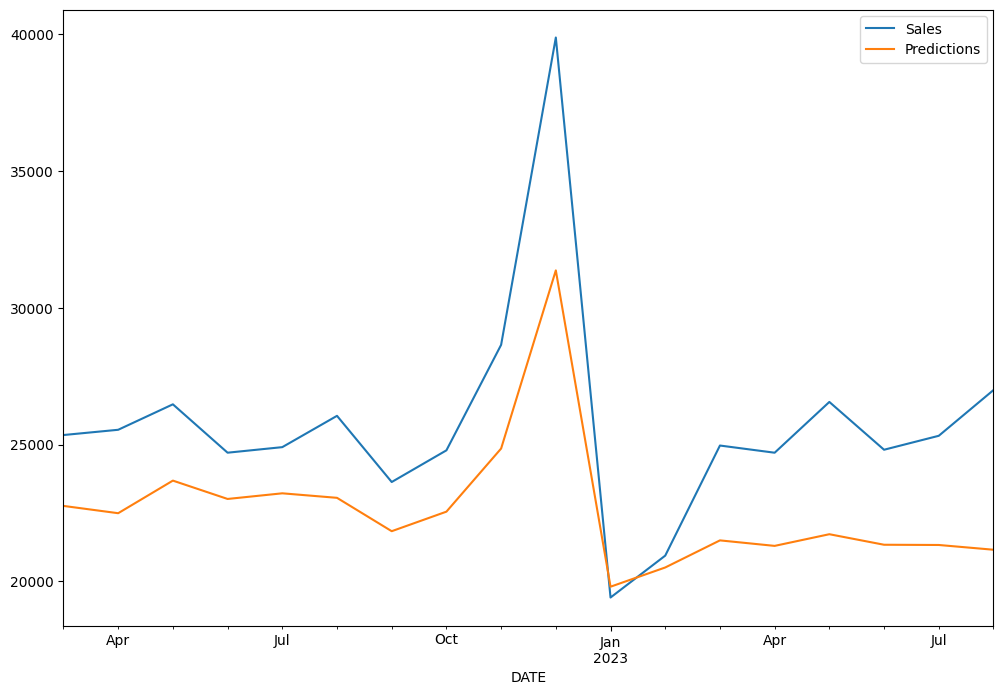

In [35]:
test.plot(figsize=(12,8));

# Retrain and Forecasting

In [36]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [37]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [38]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=8)

Epoch 1/8


C:\Users\diasrodr\AppData\Local\Temp\ipykernel_27700\853647718.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=8)


368/368 [==============================] - 10s 20ms/step - loss: 0.0158
Epoch 2/8
368/368 [==============================] - 16s 44ms/step - loss: 0.0123
Epoch 3/8
368/368 [==============================] - 5s 14ms/step - loss: 0.0086
Epoch 4/8
368/368 [==============================] - 5s 12ms/step - loss: 0.0059
Epoch 5/8
368/368 [==============================] - 5s 15ms/step - loss: 0.0057
Epoch 6/8
368/368 [==============================] - 7s 18ms/step - loss: 0.0042
Epoch 7/8
368/368 [==============================] - 12s 33ms/step - loss: 0.0039
Epoch 8/8
368/368 [==============================] - 7s 18ms/step - loss: 0.0040


In [39]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 46ms/step


In [40]:
forecast = scaler.inverse_transform(forecast)

### Creating new timestamp index with pandas.

In [41]:
df.head()

,Sales
DATE,
1992-01-01,6938.0
1992-02-01,7524.0
1992-03-01,8475.0
1992-04-01,9401.0
1992-05-01,9558.0


In [42]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [44]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

forecast_df.head()

,Forecast
2019-11-01,22370.838350
2019-12-01,23010.728670
2020-01-01,26188.260457
2020-02-01,28278.835086
2020-03-01,19767.911319


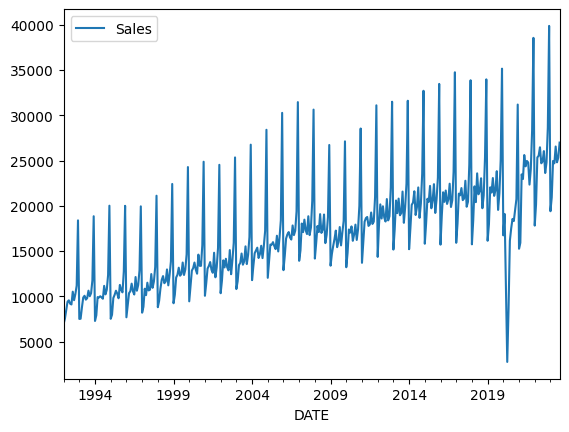

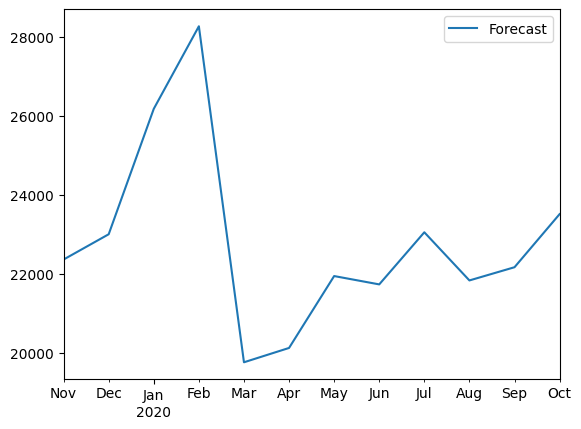

In [45]:
df.plot();
forecast_df.plot();

### Joining pandas plots

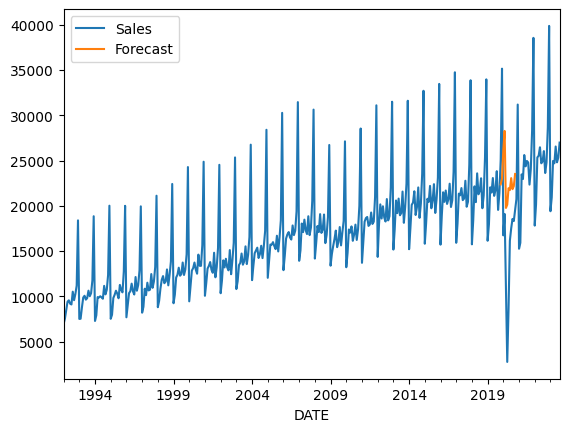

In [46]:
ax = df.plot();
forecast_df.plot(ax=ax);

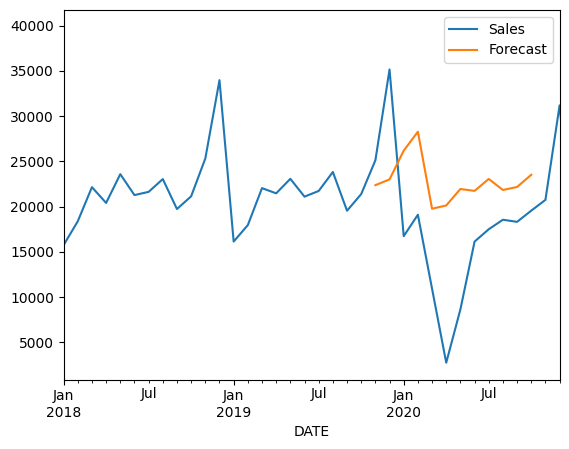

In [47]:
ax = df.plot();
forecast_df.plot(ax=ax);
plt.xlim('2018-01-01','2020-12-01');